<a href="https://colab.research.google.com/github/chien-sheng-liu/display-advertising-challenge/blob/main/merkel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 安裝兼容的 tensorflow 版本
!pip install tensorflow==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 43.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing 

In [2]:
# 安裝 deepctr
!pip install deepctr==0.9.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.8.0 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import ADASYN
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

In [4]:
!wget -c https://labs.criteo.com/wp-content/uploads/2015/04/dac_sample.tar.gz -O - | tar -xz

--2024-06-12 22:16:57--  https://labs.criteo.com/wp-content/uploads/2015/04/dac_sample.tar.gz
Resolving labs.criteo.com (labs.criteo.com)... 87.98.154.146
Connecting to labs.criteo.com (labs.criteo.com)|87.98.154.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8787154 (8.4M) [application/x-gzip]
Saving to: ‘STDOUT’

-                     2%[                    ] 211.43K   364KB/s               tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
-                   100%[===================>]   8.38M  5.68MB/s    in 1.5s    

2024-06-12 22:16:59 (5.68 MB/s) - written to stdout [8787154/8787154]

tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHIL

In [5]:
columns = ['label', *(f'I{i}' for i in range(1, 14)), *(f'C{i}' for i in range(1, 27))]
df = pd.read_csv('dac_sample.txt', sep='\t', names=columns).fillna(0)
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,0,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,0,0,e587c466,ad3062eb,3a171ecb,3b183c5c,0,0
3,0,0.0,893,0.0,0.0,4392.0,0.0,0.0,0.0,0.0,...,1e88c74f,74ef3502,0,0,6b3a5ca6,0,3a171ecb,9117a34a,0,0
4,0,3.0,-1,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,0,0,21c9516a,0,32c7478e,b34f3128,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,1.0,60,37.0,0.0,1.0,0.0,4.0,0.0,23.0,...,e5ba7672,38b82d9f,21ddcdc9,b1252a9d,24e5131b,0,32c7478e,4fa16304,47907db5,72966777
99996,1,0.0,0,12.0,0.0,173121.0,0.0,0.0,3.0,10.0,...,e5ba7672,b04e4670,21ddcdc9,b1252a9d,60f6221e,0,32c7478e,43f13e8b,ea9a246c,731c3655
99997,0,10.0,2,1.0,26.0,482.0,60.0,10.0,11.0,60.0,...,07c540c4,a7e06874,21ddcdc9,a458ea53,514b7308,0,32c7478e,2fd70e1c,010f6491,ec26ad35
99998,0,0.0,390,43.0,4.0,345365.0,0.0,0.0,4.0,4.0,...,e5ba7672,1cdbd1c5,0,0,d9d9202f,0,32c7478e,8fc66e78,0,0


label
0    77337
1    22663
Name: count, dtype: int64


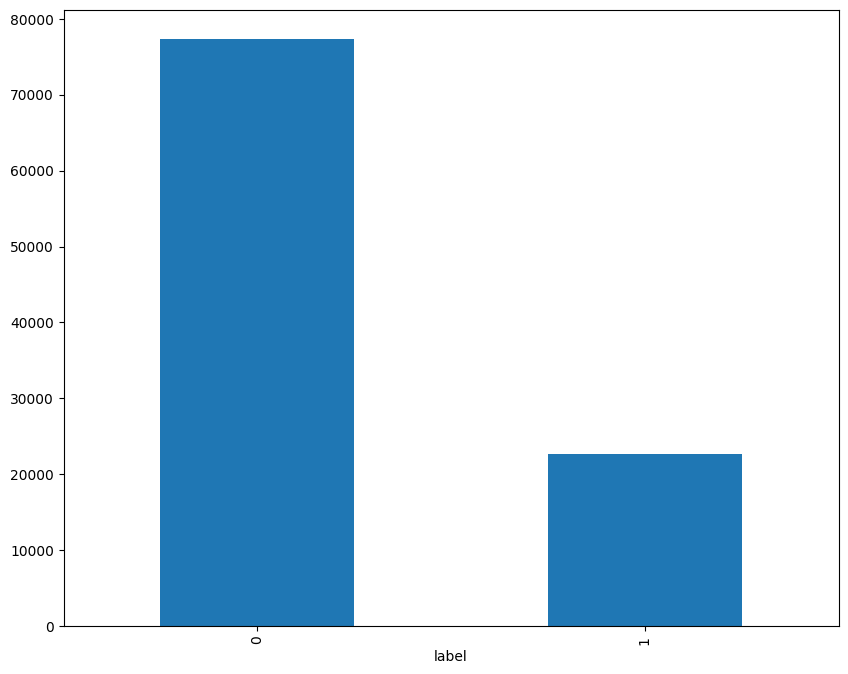

In [6]:
# Check the distribution between 1 and 0

df.label.value_counts().plot(kind='bar',figsize=(10,8))
print(df.label.value_counts())

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 40 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   100000 non-null  int64  
 1   I1      100000 non-null  float64
 2   I2      100000 non-null  int64  
 3   I3      100000 non-null  float64
 4   I4      100000 non-null  float64
 5   I5      100000 non-null  float64
 6   I6      100000 non-null  float64
 7   I7      100000 non-null  float64
 8   I8      100000 non-null  float64
 9   I9      100000 non-null  float64
 10  I10     100000 non-null  float64
 11  I11     100000 non-null  float64
 12  I12     100000 non-null  float64
 13  I13     100000 non-null  float64
 14  C1      100000 non-null  object 
 15  C2      100000 non-null  object 
 16  C3      100000 non-null  object 
 17  C4      100000 non-null  object 
 18  C5      100000 non-null  object 
 19  C6      100000 non-null  object 
 20  C7      100000 non-null  object 
 21  C8      100

In [8]:
df.describe()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,0.226630,2.094920,112.863730,32.961820,6.662840,1.675519e+04,104.614350,14.50376,13.560300,119.382240,0.344700,2.287000,0.21400,9.340200
std,0.418653,8.013892,401.522636,484.895552,10.259874,6.432196e+04,327.389364,63.97874,46.518803,280.835538,0.591393,4.547931,2.57525,46.911663
min,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000,1.220000e+02,0.000000,0.00000,2.000000,8.000000,0.000000,0.000000,0.00000,1.000000
50%,0.000000,0.000000,3.000000,5.000000,3.000000,1.903000e+03,16.000000,2.00000,8.000000,36.000000,0.000000,1.000000,0.00000,3.000000
75%,0.000000,1.000000,40.000000,17.000000,9.000000,9.279000e+03,79.000000,10.00000,20.000000,113.000000,1.000000,2.000000,0.00000,10.000000
max,1.000000,556.000000,18522.000000,65535.000000,417.000000,1.741128e+06,16290.000000,8807.00000,4677.000000,12661.000000,6.000000,104.000000,493.00000,6558.000000


In [9]:
unique_counts = df.nunique()
print(unique_counts)

# The value is extremely discrete

label        2
I1         152
I2        2693
I3         943
I4         135
I5       23041
I6        2055
I7         628
I8         155
I9        1942
I10          7
I11         86
I12         71
I13        273
C1         541
C2         497
C3       43870
C4       25184
C5         145
C6          12
C7        7623
C8         257
C9           3
C10      10997
C11       3799
C12      41312
C13       2796
C14         26
C15       5238
C16      34617
C17         10
C18       2548
C19       1303
C20          4
C21      38618
C22         11
C23         14
C24      12335
C25         51
C26       9527
dtype: int64


<Figure size 1000x600 with 0 Axes>

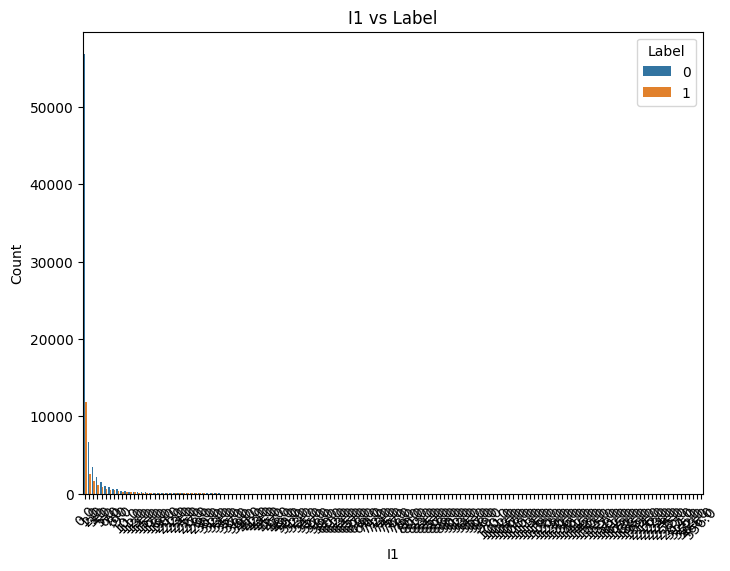

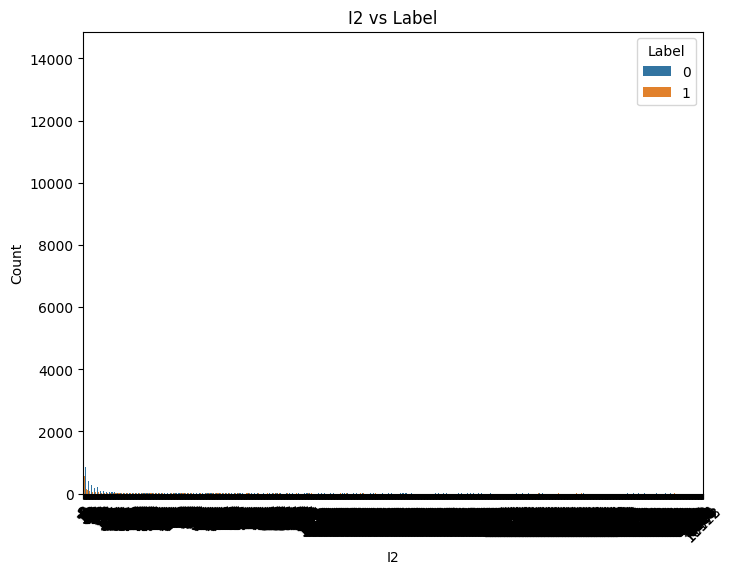

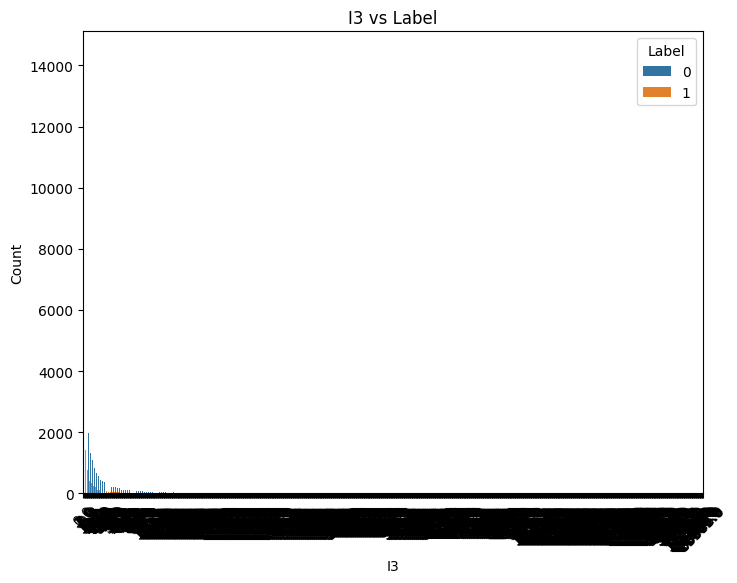

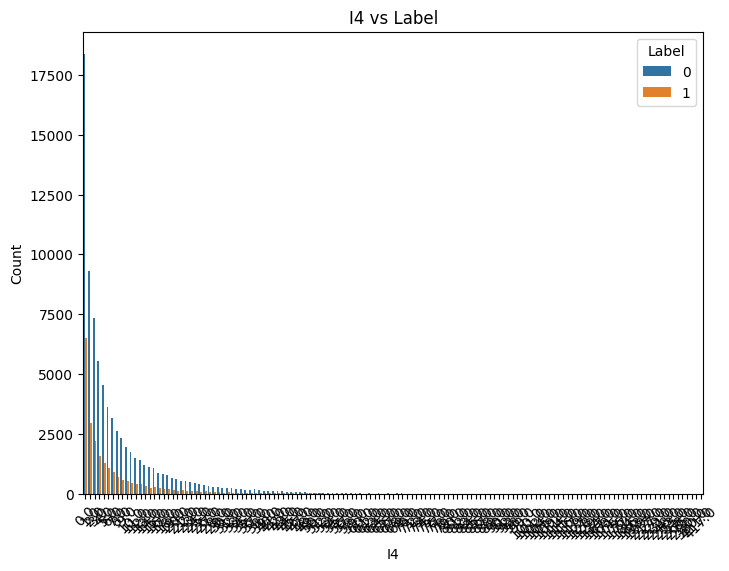

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

for column in df.columns:
    if column == 'label':
        continue

    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, hue='label', data=df)
    plt.title(f'{column} vs Label')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(title='Label', loc='upper right')
    plt.xticks(rotation=45)
    plt.show()


# Feature Engineering

In [10]:
def feature_engineering(df):
  numerical_features = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13']
  scaler = StandardScaler()
  df[numerical_features] = scaler.fit_transform(df[numerical_features])

  categorical_features = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                        'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26']

  df[categorical_features] = df[categorical_features].astype(str)

  for col in categorical_features:
      df[col] = LabelEncoder().fit_transform(df[col])

  X_numerical = df[numerical_features].values
  X_categorical = df[categorical_features].values
  y = df['label'].values

  return X_numerical, X_categorical, y

# DeepFM Feature Engineerinng

In [14]:
sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I' + str(i) for i in range(1, 14)]

target = ['label']

In [ ]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=max_encoded_values[feat] + 1, embedding_dim=8)
                       for feat in sparse_features] + [DenseFeat(feat, 1,)
                        for feat in dense_features]

In [ ]:
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [ ]:
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))
test_size = len(df) - train_size - val_size

train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

train_model_input = {name: train_df[name] for name in feature_names}
val_model_input = {name: val_df[name] for name in feature_names}
test_model_input = {name: test_df[name] for name in feature_names}

In [13]:
# Prepare the input data for the model
train_model_input = {name: train_model_input[name] for name in feature_names}
val_model_input = {name: val_model_input[name] for name in feature_names}
test_model_input = {name: test_model_input[name] for name in feature_names}

NameError: name 'feature_names' is not defined

In [ ]:
y_train = {'prediction_layer': train_df['label']}
y_val = val_df['label']
y_test = test_df['label']

In [ ]:
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
train_model_input, y_train = adasyn.fit_resample(pd.DataFrame(train_model_input), y_train['prediction_layer'])
train_model_input = {name: train_model_input[name] for name in feature_names}

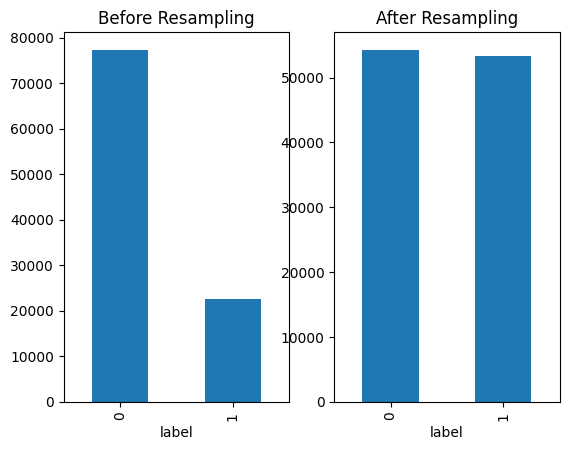

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of the target variable before resampling
plt.subplot(1, 2, 1)
df['label'].value_counts().plot(kind='bar')
plt.title('Before Resampling')

# Plot the distribution of the target variable after resampling
plt.subplot(1, 2, 2)
pd.Series(y_train).value_counts().plot(kind='bar')
plt.title('After Resampling')
plt.show()


# Training

In [ ]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary', dnn_hidden_units=[256, 256, 256], dnn_dropout=0.2, l2_reg_dnn=1e-03)


In [ ]:
model.compile(optimizer="SGD", loss="binary_crossentropy", metrics=['Precision', 'Recall', 'accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(train_model_input, y_train, batch_size=128, epochs=300, verbose=2, validation_data=(val_model_input, y_val), callbacks=[early_stopping])

Epoch 1/300
841/841 - 32s - loss: 1.3941 - precision: 0.7033 - recall: 0.5331 - accuracy: 0.6574 - val_loss: 1.3275 - val_precision: 0.3818 - val_recall: 0.4664 - val_accuracy: 0.7095
Epoch 2/300
841/841 - 23s - loss: 1.2552 - precision: 0.7915 - recall: 0.7194 - accuracy: 0.7672 - val_loss: 1.2772 - val_precision: 0.3922 - val_recall: 0.4540 - val_accuracy: 0.7183
Epoch 3/300
841/841 - 24s - loss: 1.1939 - precision: 0.8062 - recall: 0.7449 - accuracy: 0.7850 - val_loss: 1.2443 - val_precision: 0.3976 - val_recall: 0.4502 - val_accuracy: 0.7223
Epoch 4/300
841/841 - 26s - loss: 1.1457 - precision: 0.8182 - recall: 0.7564 - accuracy: 0.7961 - val_loss: 1.2085 - val_precision: 0.3975 - val_recall: 0.4150 - val_accuracy: 0.7263
Epoch 5/300
841/841 - 22s - loss: 1.1059 - precision: 0.8256 - recall: 0.7621 - accuracy: 0.8024 - val_loss: 1.1857 - val_precision: 0.3983 - val_recall: 0.4235 - val_accuracy: 0.7259
Epoch 6/300
841/841 - 24s - loss: 1.0697 - precision: 0.8326 - recall: 0.7673 - 

In [ ]:
pred_ans = model.predict(test_model_input, batch_size=128)

In [ ]:
y_pred_binary = [1 if pred > 0.5 else 0 for pred in pred_ans]

In [ ]:
from sklearn.metrics import log_loss, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, precision_score, recall_score

logloss = log_loss(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
class_f1 = classification_report(y_test, y_pred_binary, output_dict=True)

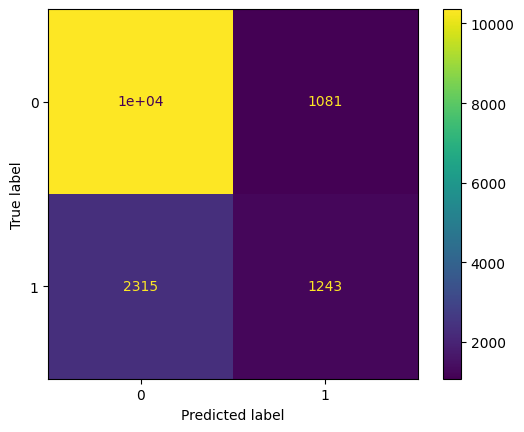

In [ ]:
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
# Print the evaluation metrics
print("Test LogLoss:", round(logloss, 4))
print("Test AUC:", round(auc, 4))
print("Classification Report:")
print(pd.DataFrame(class_f1))

Test LogLoss: 8.1603
Test AUC: 0.6274
Classification Report:
                      0            1  accuracy     macro avg  weighted avg
precision      0.817371     0.534854    0.7736      0.676113      0.750358
recall         0.905524     0.349354    0.7736      0.627439      0.773600
f1-score       0.859192     0.422645    0.7736      0.640919      0.755643
support    11442.000000  3558.000000    0.7736  15000.000000  15000.000000


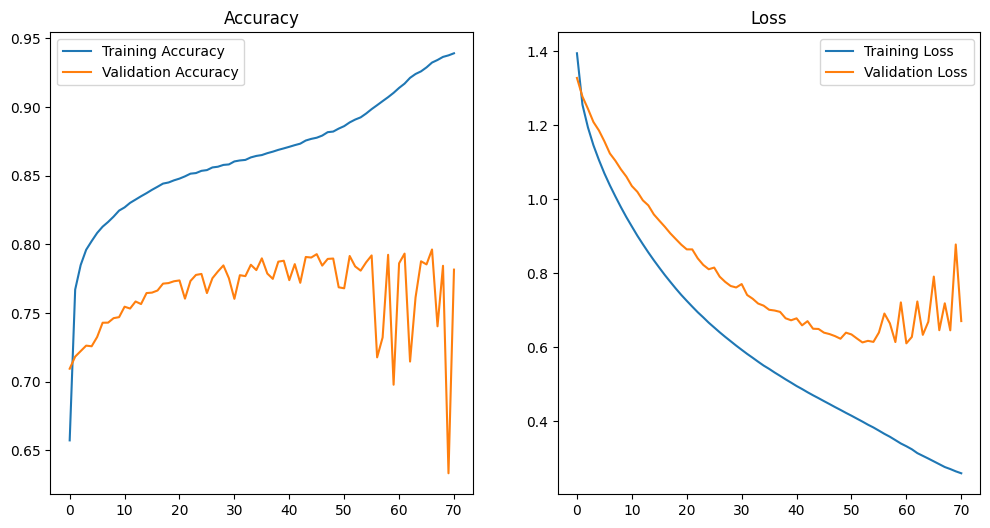

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.savefig('learning_curve.png')

plt.show()

# Predicting

In [ ]:
predicting = pd.read_csv('test.txt', sep='\t', names=columns).fillna(0)
predicting.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0.0,29,50.0,5.0,7260.0,437.0,1.0,4.0,14.0,0.0,...,1616f155,21ddcdc9,5840adea,2c277e62,0,423fab69,54c91918,9b3e8820,e75c9ae9,0.0
1,27.0,17,45.0,28.0,2.0,28.0,27.0,29.0,28.0,1.0,...,b4abdd09,21ddcdc9,5840adea,36a7ab86,0,32c7478e,85e4d73f,010f6491,ee63dd9b,0.0
2,1.0,1,19.0,7.0,1.0,3.0,1.0,7.0,7.0,1.0,...,bd17c3da,1d04f4a4,a458ea53,82bdc0bb,0,32c7478e,5bdcd9c4,010f6491,cca57dcc,0.0
3,4.0,1,0.0,6.0,1051.0,134.0,4.0,35.0,72.0,1.0,...,bdc06043,0,0,6dfd157c,ad3062eb,423fab69,ef089725,0,0,0.0
4,7.0,1,25.0,10.0,139.0,74.0,48.0,13.0,44.0,1.0,...,395856b0,21ddcdc9,a458ea53,9c3eb598,ad3062eb,3a171ecb,c0b8dfd6,001f3601,7a2fb9af,0.0


In [ ]:
numerical_features = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])